
# Toy example: Piecewise linear function

## Testing the Neural Incremental Posterior Estimation

#### Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [41]:
from utils import helpers
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

In [42]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C


import utils
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

## Piecewise_linear() and simulation wrappers for SBI

- piecewise_linear is taking 6 parameters (changing points and slopes) and outputs a three-part piecewise linear function

- piecewise_linear_seq is taking a list of either 2, 3 or 4 parameters and then outputs either a one-part. a two-part or a three-part piecewise linear function

In [43]:
start = get_time()



def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_seq(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    add_noise=0.2
    
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    
    if (len(thetas)==2):
        a1 = thetas[0]
        b = thetas[1]
        
        if not add_noise == None:
            a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)  
            
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
        
        return y[x<cp1]
    
     
    if (len(thetas)==3):     
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        
        if not add_noise == None:
            a1,b, a2 = np.array([a1,b, a2]) + scp.random.normal(scale=add_noise,size=3)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
        
        return y[x<cp2]
    
    
    if (len(thetas)==4):
        
        
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        a3 = thetas[3]
        
        if not add_noise == None:
            a1,b, a2, a3 = np.array([a1,b, a2, a3]) + scp.random.normal(scale=add_noise,size=4)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
        # third piece
        y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
        
        return y

    
  

### Define prior and summary stats dependent on prior

In [44]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



## **Summary statistics**

definition of summary statistics for the piecewise linear function

In [45]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    

    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        step_size = max_time/len(batch)
        
        
        x = torch.arange(0, max_time, step_size, dtype=torch.float64)
        
        
        
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(10) * np.nan
        
        s[0] = np.float32(batch[0])    #offset
        s[1] = np.nanmin(batch[x<4])   # local min
        
        #print(type(s[0]), type(s[1]))
        s[2] = np.nanargmin(batch[x<4])   #value of min
    

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[3] = np.nanmax(batch[(x>=4)&(x<8)])
            s[4] = np.nanmin(batch[(x>=4)&(x<8)])
            s[5] = np.nanargmin(batch[(x>=4)&(x<8)])

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[6] = np.nanmin(batch[x>=5])
            s[7] = np.nanargmin(batch[x>=5])
            
            s[8] = np.nanmax(batch[x>=5])
            s[9] = np.nanargmax(batch[x>=5])
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    
    

## Sequential Time Series SBI


We have the following parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [46]:
#parameter a1,b,a2,a3, cp1, cp2


prior_min = [3, 3, -5, 0]  

prior_max = [7, 7, -1, 4]

num_simulations=300

## First round

In [47]:
### first round:
from sbi import utils as utils

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])


#inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior1)
inf = SNPE_C(prior, density_estimator=density_estimator)


theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [48]:
x = extract_sumstats(x_without)

In [49]:
inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

 Neural network successfully converged after 75 epochs.

In [50]:
true_params = [5, 5]
obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])


In [51]:
num_samples = 1000

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

So, the parameter range takes now only 15.775% of the uniform prior space!!

## Second round

In [52]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:3], high = prior_max[2:3])


prior_combined =Combined(proposal1, prior2, number_params_1=2)



density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined)

inf = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[4.9539, 5.1619]])
theta prior tensor([[-2.0567]])
theta shape torch.Size([1, 3])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[4.3372, 5.3905]])
theta prior tensor([[-4.1283]])
theta shape torch.Size([1, 3])
tensor([-2.6767])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[4.5772, 5.8024]])
theta prior tensor([[-1.2205]])
theta shape torch.Size([1, 3])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[4.3876, 5.6376]])
theta prior tensor([[-2.3173]])
theta shape torch.Size([1, 3])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[5.0039, 5.2763]])
theta prior tensor([[-3.8125]])
theta shape torch.Size([1, 3])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[4.5493, 5.1227],
        [5.2926, 5.5809]])
theta prior tensor([[-1.9200],
        [-3.9343]])
theta shape torch.Size([2, 3])


/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[5.0084, 5.3677]])
theta prior tensor([[-4.7831]])
theta shape torch.Size([1, 3])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[5.1147, 5.2253]])
theta prior tensor([[-1.5735]])
theta shape torch.Size([1, 3])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[4.9080, 5.5156]])
theta prior tensor([[-2.9309]])
theta shape torch.Size([1, 3])


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

theta posterior tensor([[4.9438, 5.2887],
        [6.2092, 5.3204],
        [4.9930, 5.3988],
        [4.7886, 5.3066],
        [4.7663, 5.5064],
        [4.2588, 5.7881],
        [4.8197, 5.2930],
        [4.9973, 5.5451],
        [4.7793, 5.2004],
        [4.8112, 5.7768],
        [5.2051, 5.0531],
        [4.9104, 5.0336],
        [4.8562, 5.3001],
        [5.1104, 5.0815],
        [4.7430, 5.7352],
        [5.0100, 5.2795],
        [4.9320, 5.2692],
        [5.3666, 5.5964],
        [5.2096, 5.2567],
        [5.0852, 5.4935],
        [5.4526, 5.4181],
        [3.9140, 5.7501],
        [4.8868, 5.4205],
        [4.7314, 5.3440],
        [4.8470, 5.3854],
        [4.6655, 5.1684],
        [5.5109, 5.3013],
        [5.2106, 5.4353],
        [4.7524, 5.8460],
        [4.3803, 5.4352],
        [4.7604, 5.4219],
        [5.2870, 5.1081],
        [4.7323, 5.2255],
        [4.1551, 5.3555],
        [4.7651, 5.4511],
        [6.4342, 4.1268],
        [4.8499, 5.3103],
        [5.3569, 5.083

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [53]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

 Neural network successfully converged after 56 epochs.

In [54]:
posterior2 = inf.build_posterior(density_estimator)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.7343, 5.2985],
        [5.1500, 6.4290],
        [5.0408, 5.2719],
        ...,
        [4.2300, 5.1912],
        [5.3224, 5.4567],
        [4.6692, 5.2995]])
theta prior tensor([[-4.3412],
        [-3.2296],
        [-4.9500],
        [-4.0004],
        [-3.8562],
        [-2.2330],
        [-2.3051],
        [-2.9540],
        [-3.6792],
        [-1.7762],
        [-2.4873],
        [-3.6592],
        [-1.8613],
        [-1.4995],
        [-4.2397],
        [-1.0131],
        [-4.7385],
        [-4.2402],
        [-3.7760],
        [-1.2322],
        [-1.1560],
        [-2.2896],
        [-3.3152],
        [-3.8841],
        [-4.9276],
        [-2.9515],
        [-3.4096],
        [-4.3332],
        [-4.1935],
        [-1.8905],
        [-4.3432],
        [-2.7811],
        [-1.3871],
        [-3.0237],
        [-2.5396],
        [-4.9165],
        [-3.8324],
        [-3.5988],
        [-3.5991],
        [-3.1211],
        [-4.3616],
        [-4.5123],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.7357, 5.1070],
        [5.0864, 5.2053],
        [5.2420, 5.6449],
        ...,
        [5.0206, 4.9557],
        [5.6855, 5.5001],
        [4.7654, 5.1604]])
theta prior tensor([[-4.6974],
        [-2.6900],
        [-2.9011],
        [-3.2759],
        [-4.4366],
        [-1.0500],
        [-3.6557],
        [-3.2329],
        [-3.1331],
        [-3.8206],
        [-3.1108],
        [-3.6906],
        [-1.4890],
        [-1.5785],
        [-3.8051],
        [-3.1389],
        [-4.7698],
        [-2.5373],
        [-4.8316],
        [-4.7504],
        [-3.3919],
        [-3.6324],
        [-2.7882],
        [-2.0465],
        [-3.4440],
        [-4.5701],
        [-1.4561],
        [-4.2869],
        [-2.7891],
        [-4.4747],
        [-2.7482],
        [-4.3558],
        [-3.8352],
        [-4.8365],
        [-3.9242],
        [-3.0734],
        [-4.1966],
        [-2.7594],
        [-3.5018],
        [-3.0826],
        [-2.9385],
        [-1.1004],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.7901, 5.5145],
        [4.1423, 5.7459],
        [4.6673, 5.2360],
        ...,
        [5.1157, 5.4614],
        [4.7020, 5.5164],
        [5.0683, 5.2491]])
theta prior tensor([[-4.3871],
        [-1.6548],
        [-1.4535],
        [-1.8191],
        [-3.5863],
        [-3.7044],
        [-1.3412],
        [-3.8473],
        [-1.9772],
        [-4.3065],
        [-3.7652],
        [-3.9682],
        [-4.5107],
        [-2.5472],
        [-3.5330],
        [-1.7952],
        [-2.8299],
        [-1.3913],
        [-4.1973],
        [-4.6162],
        [-4.5059],
        [-1.1681],
        [-3.2736],
        [-4.3048],
        [-1.2150],
        [-1.2626],
        [-4.0683],
        [-2.0126],
        [-2.2714],
        [-2.3072],
        [-3.2802],
        [-1.6624],
        [-2.6258],
        [-3.7676],
        [-2.8825],
        [-4.9074],
        [-1.2360],
        [-2.1005],
        [-3.9268],
        [-3.7243],
        [-3.1175],
        [-1.0683],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.8892, 6.0471],
        [5.2263, 6.3354],
        [4.8498, 5.6237],
        ...,
        [4.1115, 5.3063],
        [5.1229, 5.4910],
        [6.1895, 5.1203]])
theta prior tensor([[-2.0266],
        [-1.3280],
        [-4.7868],
        [-2.9679],
        [-4.0515],
        [-4.7494],
        [-3.8632],
        [-1.5555],
        [-1.0952],
        [-1.6617],
        [-2.9411],
        [-4.1546],
        [-1.6693],
        [-3.2666],
        [-4.6656],
        [-4.2865],
        [-1.3016],
        [-1.1669],
        [-4.7686],
        [-2.2770],
        [-3.0527],
        [-4.5034],
        [-4.5204],
        [-2.8683],
        [-3.7899],
        [-1.6486],
        [-2.4643],
        [-1.7746],
        [-1.5456],
        [-3.1248],
        [-3.2477],
        [-1.7215],
        [-4.5878],
        [-1.4464],
        [-1.1568],
        [-1.2679],
        [-1.5245],
        [-4.4908],
        [-3.5718],
        [-3.0649],
        [-4.8117],
        [-3.8632],
    

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[4.7895, 5.2323],
        [5.1379, 5.4997]])
theta prior tensor([[-2.3057],
        [-1.3943]])
theta shape torch.Size([2, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[5.2331, 5.2471],
        [4.7701, 5.2282],
        [3.9446, 5.5773],
        ...,
        [4.7446, 5.9387],
        [5.1252, 5.1827],
        [4.7722, 5.4436]])
theta prior tensor([[-1.3226],
        [-2.6523],
        [-3.0582],
        [-3.4152],
        [-1.3573],
        [-4.6701],
        [-4.8037],
        [-3.7178],
        [-4.3979],
        [-4.2345],
        [-2.2912],
        [-4.4433],
        [-1.1743],
        [-1.8094],
        [-4.7321],
        [-4.7216],
        [-3.2234],
        [-1.3394],
        [-2.3016],
        [-4.2730],
        [-2.0313],
        [-3.7738],
        [-1.8526],
        [-3.8768],
        [-2.1915],
        [-3.8567],
        [-2.7538],
        [-4.7968],
        [-2.1352],
        [-2.3985],
        [-2.3223],
        [-4.1201],
        [-2.8955],
        [-3.9341],
        [-3.8516],
        [-3.8266],
        [-2.0353],
        [-2.2711],
        [-4.9538],
        [-3.6936],
        [-3.0975],
        [-3.3032],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.7666, 4.5619],
        [5.0965, 5.3980],
        [4.9197, 5.2792],
        ...,
        [5.1299, 5.4789],
        [5.1999, 5.2232],
        [4.8099, 5.4631]])
theta prior tensor([[-1.4790],
        [-3.3882],
        [-2.3265],
        [-3.2276],
        [-3.5873],
        [-2.0837],
        [-2.3941],
        [-4.7382],
        [-1.4253],
        [-1.3754],
        [-2.0345],
        [-1.2146],
        [-3.7244],
        [-3.2472],
        [-3.5418],
        [-2.1910],
        [-2.7108],
        [-1.7520],
        [-1.0589],
        [-2.5001],
        [-1.3305],
        [-1.9561],
        [-4.5885],
        [-2.9167],
        [-3.0033],
        [-3.5159],
        [-1.1430],
        [-3.4273],
        [-3.6884],
        [-4.7958],
        [-1.5373],
        [-1.4313],
        [-4.7272],
        [-4.8612],
        [-2.5155],
        [-1.1318],
        [-1.4858],
        [-1.0738],
        [-2.4473],
        [-2.7218],
        [-3.0141],
        [-3.8041],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[4.7819, 4.4429],
        [4.9142, 5.6026],
        [5.2165, 5.9782],
        ...,
        [4.8605, 5.3056],
        [4.6165, 6.0276],
        [5.3142, 5.0743]])
theta prior tensor([[-1.2983],
        [-4.8114],
        [-1.6151],
        [-2.3009],
        [-4.3817],
        [-2.3546],
        [-2.7180],
        [-2.6018],
        [-4.7125],
        [-4.0970],
        [-3.7937],
        [-2.5314],
        [-3.3248],
        [-3.0551],
        [-2.2842],
        [-4.8700],
        [-1.4776],
        [-2.3466],
        [-4.4315],
        [-1.1735],
        [-1.5728],
        [-1.9081],
        [-4.5610],
        [-3.6803],
        [-2.9779],
        [-3.0949],
        [-3.9807],
        [-1.9212],
        [-1.5891],
        [-3.2766],
        [-2.9256],
        [-2.4055],
        [-4.0530],
        [-1.5092],
        [-1.7165],
        [-3.5520],
        [-2.4042],
        [-1.7960],
        [-1.0686],
        [-2.1058],
        [-2.6656],
        [-4.7194],
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[5.0900, 6.0585],
        [4.7933, 5.5966],
        [3.9430, 5.3815],
        ...,
        [5.0203, 5.6494],
        [4.6977, 5.1067],
        [4.8912, 5.5151]])
theta prior tensor([[-1.2500],
        [-1.2712],
        [-2.5338],
        [-2.5743],
        [-3.7561],
        [-3.9756],
        [-3.9077],
        [-2.1358],
        [-3.0771],
        [-2.2015],
        [-4.2431],
        [-4.2803],
        [-2.0486],
        [-4.8003],
        [-3.6762],
        [-1.3216],
        [-4.7798],
        [-4.2107],
        [-2.4227],
        [-2.1706],
        [-2.5862],
        [-4.7879],
        [-4.1557],
        [-3.4289],
        [-3.6543],
        [-2.6038],
        [-1.0212],
        [-4.9132],
        [-3.5500],
        [-1.6114],
        [-1.6064],
        [-2.4608],
        [-4.9718],
        [-1.3452],
        [-2.5230],
        [-3.5364],
        [-4.6557],
        [-2.6659],
        [-4.3311],
        [-2.6004],
        [-1.1779],
        [-1.6122],
    

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[4.8378, 5.4512],
        [3.5864, 5.8659]])
theta prior tensor([[-1.7356],
        [-1.0050]])
theta shape torch.Size([2, 3])


In [55]:
true_params = [5,5,-3]


obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])


#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
import sbi
print(sbi.__version__)

0.17.2


## Third and last round

In [56]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=[prior_min[3]], high = [prior_max[3]])


prior_combined2 = Combined(proposal2, prior3, number_params_1=3)



density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined2)

inf = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 5.8103,  5.5355, -2.7574]])
theta prior tensor([[0.3495]])
theta shape torch.Size([1, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 4.7783,  5.1797, -1.3927]])
theta prior tensor([[1.8228]])
theta shape torch.Size([1, 4])
tensor([-3.8478])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 4.8577,  5.0735, -2.6413]])
theta prior tensor([[2.1676]])
theta shape torch.Size([1, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 5.0533,  5.2509, -3.8547]])
theta prior tensor([[0.7816]])
theta shape torch.Size([1, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 4.8413,  5.3532, -3.0719]])
theta prior tensor([[0.4206]])
theta shape torch.Size([1, 4])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[ 4.9020,  5.2323, -2.5034],
        [ 4.4045,  5.1110, -2.5754]])
theta prior tensor([[3.3084],
        [1.3812]])
theta shape torch.Size([2, 4])


/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 4.7576,  4.6871, -2.6963]])
theta prior tensor([[3.6447]])
theta shape torch.Size([1, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 4.8956,  5.0390, -2.6771]])
theta prior tensor([[2.5660]])
theta shape torch.Size([1, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta posterior tensor([[ 4.9863,  4.8193, -2.5321]])
theta prior tensor([[1.2389]])
theta shape torch.Size([1, 4])


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

theta posterior tensor([[ 4.4666,  5.3688, -2.7081],
        [ 5.0449,  5.1203, -2.6781],
        [ 4.8998,  5.4883, -2.8160],
        [ 4.9511,  5.2391, -3.6589],
        [ 4.4552,  5.1808, -4.4152],
        [ 4.9923,  5.0293, -2.3887],
        [ 4.8187,  5.3325, -5.0606],
        [ 4.8855,  5.4183, -2.4686],
        [ 5.2301,  4.8206, -4.2985],
        [ 4.8441,  5.3543, -2.8582],
        [ 4.7176,  5.2190, -2.0116],
        [ 5.0734,  5.2982, -2.5779],
        [ 4.6673,  5.5048, -4.2477],
        [ 5.0387,  5.1940, -2.2713],
        [ 4.7378,  5.1766, -3.1210],
        [ 4.9787,  4.6242, -2.5684],
        [ 4.8089,  5.1932, -3.8186],
        [ 5.0295,  5.1822, -2.9054],
        [ 4.8240,  5.3661, -2.6811],
        [ 4.7356,  5.3755, -2.9241],
        [ 4.9711,  5.6512, -3.1021],
        [ 4.8678,  5.3864, -3.2042],
        [ 4.7303,  5.2616, -3.3118],
        [ 4.9896,  5.1782, -3.2520],
        [ 5.2546,  4.8585, -3.1560],
        [ 4.9037,  5.0982, -2.9281],
        [ 4.8771,  5.3

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [57]:
x = extract_sumstats(x_without)


print(x.shape)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

torch.Size([300, 10])
 Neural network successfully converged after 66 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 4.9749,  4.9712, -2.3044],
        [ 4.7423,  5.0022, -3.3642],
        [ 5.0580,  4.6821, -2.7717],
        ...,
        [ 4.7054,  5.5010, -3.1821],
        [ 4.0826,  5.4157, -2.6395],
        [ 5.2227,  5.1706, -2.9271]])
theta prior tensor([[2.8178e+00],
        [1.1319e+00],
        [3.8521e+00],
        [3.5178e+00],
        [1.0622e+00],
        [1.1927e+00],
        [3.6285e+00],
        [2.6861e+00],
        [6.8679e-01],
        [9.7162e-01],
        [8.8369e-02],
        [3.4520e+00],
        [3.4586e+00],
        [3.1376e+00],
        [3.9390e+00],
        [2.5617e+00],
        [1.3748e+00],
        [3.7082e+00],
        [3.9057e+00],
        [3.1108e+00],
        [1.0586e+00],
        [7.1976e-01],
        [1.4235e+00],
        [9.9708e-01],
        [1.6301e-01],
        [1.7889e+00],
        [2.7625e+00],
        [2.1885e+00],
        [2.5559e+00],
        [2.9361e+00],
        [3.8464e+00],
        [2.9900e+00],
        [3.7260e+00],
        [3

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 5.2858,  5.2478, -3.1817],
        [ 4.8115,  5.1391, -2.3485],
        [ 5.0471,  5.0419, -2.5728],
        ...,
        [ 4.9288,  5.2692, -2.5521],
        [ 4.7877,  5.1656, -3.0699],
        [ 5.6495,  4.9180, -2.7870]])
theta prior tensor([[5.1008e-01],
        [2.0766e-01],
        [3.2036e+00],
        [1.0008e+00],
        [2.7292e+00],
        [1.6739e-01],
        [3.2039e+00],
        [2.6907e-01],
        [3.0823e+00],
        [3.0366e+00],
        [1.3989e+00],
        [3.0716e+00],
        [3.7105e+00],
        [1.0309e+00],
        [3.4739e+00],
        [1.8488e+00],
        [1.4991e+00],
        [2.1301e+00],
        [3.2587e+00],
        [3.4106e+00],
        [1.3913e+00],
        [2.9870e+00],
        [4.8669e-01],
        [3.4350e+00],
        [3.4878e-01],
        [3.2591e+00],
        [1.0737e+00],
        [8.2358e-01],
        [3.7653e-01],
        [1.8844e+00],
        [4.3226e-01],
        [6.7206e-01],
        [1.7627e+00],
        [3

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 5.2428,  5.4333, -2.9957],
        [ 4.8263,  5.5668, -2.9691],
        [ 5.3841,  5.3833, -2.5326],
        ...,
        [ 5.2068,  4.8117, -3.1718],
        [ 4.4660,  5.3758, -2.6980],
        [ 4.8916,  5.1557, -2.2154]])
theta prior tensor([[3.4112e+00],
        [2.0447e+00],
        [1.5215e+00],
        [7.3443e-01],
        [1.5651e+00],
        [1.1353e+00],
        [1.8029e+00],
        [3.0311e+00],
        [4.3068e-01],
        [1.8875e+00],
        [4.4702e-01],
        [3.4082e+00],
        [1.2651e+00],
        [2.4017e+00],
        [3.9731e+00],
        [2.0348e+00],
        [3.4950e-01],
        [2.2574e+00],
        [2.9725e+00],
        [7.2780e-01],
        [1.6335e+00],
        [2.9935e+00],
        [2.8393e+00],
        [5.0119e-01],
        [1.9059e+00],
        [3.5172e+00],
        [4.3756e-01],
        [1.0836e+00],
        [3.3371e+00],
        [4.0150e-01],
        [3.0217e+00],
        [2.8162e+00],
        [7.2855e-01],
        [2

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 5.2561,  4.9506, -1.9029],
        [ 5.0005,  5.1568, -2.9547],
        [ 4.8236,  5.2216, -2.4853],
        ...,
        [ 4.9896,  5.4481, -3.4263],
        [ 4.9713,  5.2655, -3.2623],
        [ 4.6840,  5.2821, -2.6495]])
theta prior tensor([[2.7762e+00],
        [3.8902e+00],
        [2.7172e+00],
        [7.8449e-01],
        [8.1674e-01],
        [1.4174e-01],
        [1.0875e+00],
        [2.7268e+00],
        [2.8914e+00],
        [8.0487e-01],
        [8.9120e-01],
        [2.4350e+00],
        [2.7814e+00],
        [1.9269e+00],
        [1.4703e+00],
        [2.1243e+00],
        [2.6494e+00],
        [3.8581e+00],
        [1.3992e-01],
        [3.4250e+00],
        [1.8699e+00],
        [3.5039e+00],
        [7.4465e-01],
        [3.8276e-01],
        [3.5532e+00],
        [2.9024e+00],
        [3.9365e+00],
        [3.0470e+00],
        [7.6207e-01],
        [2.3918e+00],
        [8.0626e-01],
        [3.3053e+00],
        [3.5506e-01],
        [1

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[ 4.8222,  4.8475, -3.1703],
        [ 4.6859,  5.2445, -2.8316]])
theta prior tensor([[3.4774],
        [2.8395]])
theta shape torch.Size([2, 4])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 4.8678,  4.6763, -3.4307],
        [ 4.7298,  5.2135, -2.6828],
        [ 4.7019,  4.9215, -2.4179],
        ...,
        [ 4.7400,  5.5394, -3.0297],
        [ 5.0206,  6.1955, -2.7913],
        [ 5.1467,  5.3779, -2.7426]])
theta prior tensor([[3.9805e+00],
        [6.8565e-01],
        [1.9007e+00],
        [3.4734e+00],
        [3.7238e+00],
        [1.8433e-01],
        [1.6265e+00],
        [1.3421e+00],
        [2.8187e+00],
        [1.4050e+00],
        [1.0244e+00],
        [1.2882e-01],
        [3.6468e-01],
        [2.1695e+00],
        [1.2829e-01],
        [2.6243e+00],
        [3.3869e+00],
        [1.5804e+00],
        [2.5966e+00],
        [1.4652e+00],
        [2.0748e+00],
        [2.2075e+00],
        [2.0326e+00],
        [1.8945e+00],
        [1.4072e+00],
        [3.9151e+00],
        [2.9340e+00],
        [1.7322e+00],
        [2.5998e+00],
        [2.4587e-01],
        [3.8016e+00],
        [1.6137e+00],
        [9.2232e-01],
        [2

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 4.4226,  5.4264, -2.8496],
        [ 5.0320,  5.5751, -3.7668],
        [ 4.9195,  5.1731, -1.8680],
        ...,
        [ 4.7796,  5.1454, -2.3086],
        [ 5.0266,  5.1469, -2.4454],
        [ 5.0047,  5.4065, -2.7815]])
theta prior tensor([[1.5661],
        [0.7873],
        [1.9540],
        [1.9099],
        [1.1357],
        [2.4933],
        [1.5980],
        [3.9718],
        [1.1756],
        [3.8773],
        [1.6051],
        [0.8055],
        [1.7347],
        [2.3611],
        [3.3645],
        [0.4107],
        [0.7401],
        [3.1896],
        [2.2780],
        [1.1940],
        [1.2540],
        [3.5493],
        [2.5362],
        [1.8633],
        [3.2921],
        [3.0706],
        [1.7535],
        [1.6598],
        [0.6133],
        [1.9367],
        [0.5832],
        [3.7877],
        [2.2971],
        [1.8506],
        [2.8573],
        [0.7533],
        [3.9259],
        [0.9052],
        [3.8379],
        [0.1854],
        [2.7897]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 5.2776,  5.1694, -4.2340],
        [ 4.2041,  5.6276, -3.9387],
        [ 4.2964,  5.4620, -3.1085],
        ...,
        [ 4.9771,  5.1816, -3.5051],
        [ 4.8592,  5.1991, -3.1727],
        [ 5.1686,  4.7052, -2.9462]])
theta prior tensor([[5.6448e-01],
        [2.9400e+00],
        [1.2326e-01],
        [2.9163e+00],
        [1.8567e+00],
        [1.6767e-01],
        [3.9458e+00],
        [1.5225e+00],
        [3.2910e-01],
        [1.7545e+00],
        [3.6785e+00],
        [3.5915e-03],
        [1.6520e-02],
        [5.7183e-01],
        [2.6958e+00],
        [2.6428e+00],
        [5.0130e-01],
        [3.5320e+00],
        [2.8103e+00],
        [1.7512e+00],
        [3.2020e+00],
        [2.6881e+00],
        [3.0655e+00],
        [3.9620e+00],
        [2.7181e+00],
        [2.2616e+00],
        [1.7824e-01],
        [3.4721e+00],
        [1.2683e+00],
        [1.1576e+00],
        [2.5745e+00],
        [1.6867e-01],
        [2.3331e+00],
        [3

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta posterior tensor([[ 4.4813,  5.2326, -2.6777],
        [ 5.0586,  5.5018, -2.5835],
        [ 4.7572,  5.0501, -3.1446],
        ...,
        [ 4.7108,  5.1378, -2.8564],
        [ 5.0096,  4.8095, -2.9726],
        [ 4.7132,  5.4403, -3.9686]])
theta prior tensor([[3.5363e+00],
        [1.6788e+00],
        [2.7780e+00],
        [5.1583e-01],
        [2.6543e+00],
        [7.3175e-01],
        [2.5214e+00],
        [1.2814e+00],
        [1.2625e+00],
        [2.3727e+00],
        [3.9927e+00],
        [1.6715e+00],
        [8.7144e-01],
        [4.9145e-01],
        [1.9528e+00],
        [1.7985e+00],
        [3.4268e+00],
        [1.3628e+00],
        [3.3608e+00],
        [3.6724e+00],
        [1.2887e+00],
        [1.9637e+00],
        [1.8598e+00],
        [8.0039e-01],
        [9.5676e-01],
        [2.5632e+00],
        [3.7822e+00],
        [3.8294e+00],
        [2.4268e+00],
        [1.2998e+00],
        [2.3758e+00],
        [8.6399e-01],
        [1.1208e+00],
        [9

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta posterior tensor([[ 5.0264,  5.2384, -3.2291],
        [ 4.8999,  5.3707, -2.6836]])
theta prior tensor([[3.1667],
        [1.4738]])
theta shape torch.Size([2, 4])


In [58]:
true_params = [5, 5, -3, 2]

obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])[0]

print(obs_real_stats)


samples = posterior3.sample((1000,), x=obs_real_stats)

tensor([  4.7044,   4.7044,   0.0000,  16.4376,  10.1282, 199.0000,  10.1282,
         99.0000,  17.8606, 499.0000])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [59]:
prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)

In [60]:
end = get_time()


print('start:', start, '\nend:', end)

start: 02-27-2022_18:53:14 
end: 02-27-2022_18:53:45


In [61]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples)


s_x_prior = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples_prior)

In [62]:
s_x_stat = extract_sumstats(s_x)

s_x_prior_stat = extract_sumstats(s_x_prior)



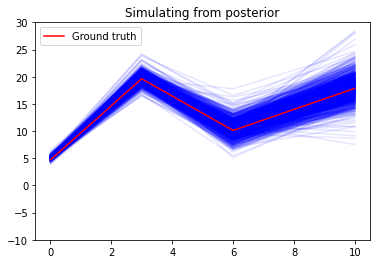

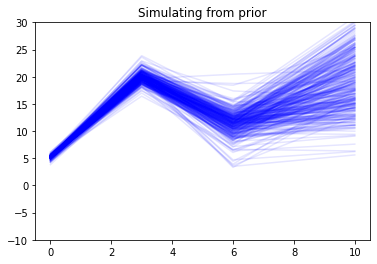

In [63]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s, alpha=0.1, color='blue')
    plt.ylim(-10,30)
plt.plot(x_lin, obs_real, label='Ground truth', color='red')
plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in x_without:
    plt.plot(x_lin, x_w, alpha=0.1, color='blue')

    plt.ylim(-10,30)


  

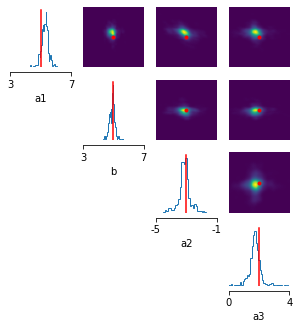

In [39]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([[5, 5, -3, 2, 1, 5]])

parameter_names = ['a1', 'b', 'a2', 'a3']

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    upper = "kde",
    points=true_params[0:2],
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)

### Validating summary statistics with histogram plots

We should see that posterior is restricting the area of values

10
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


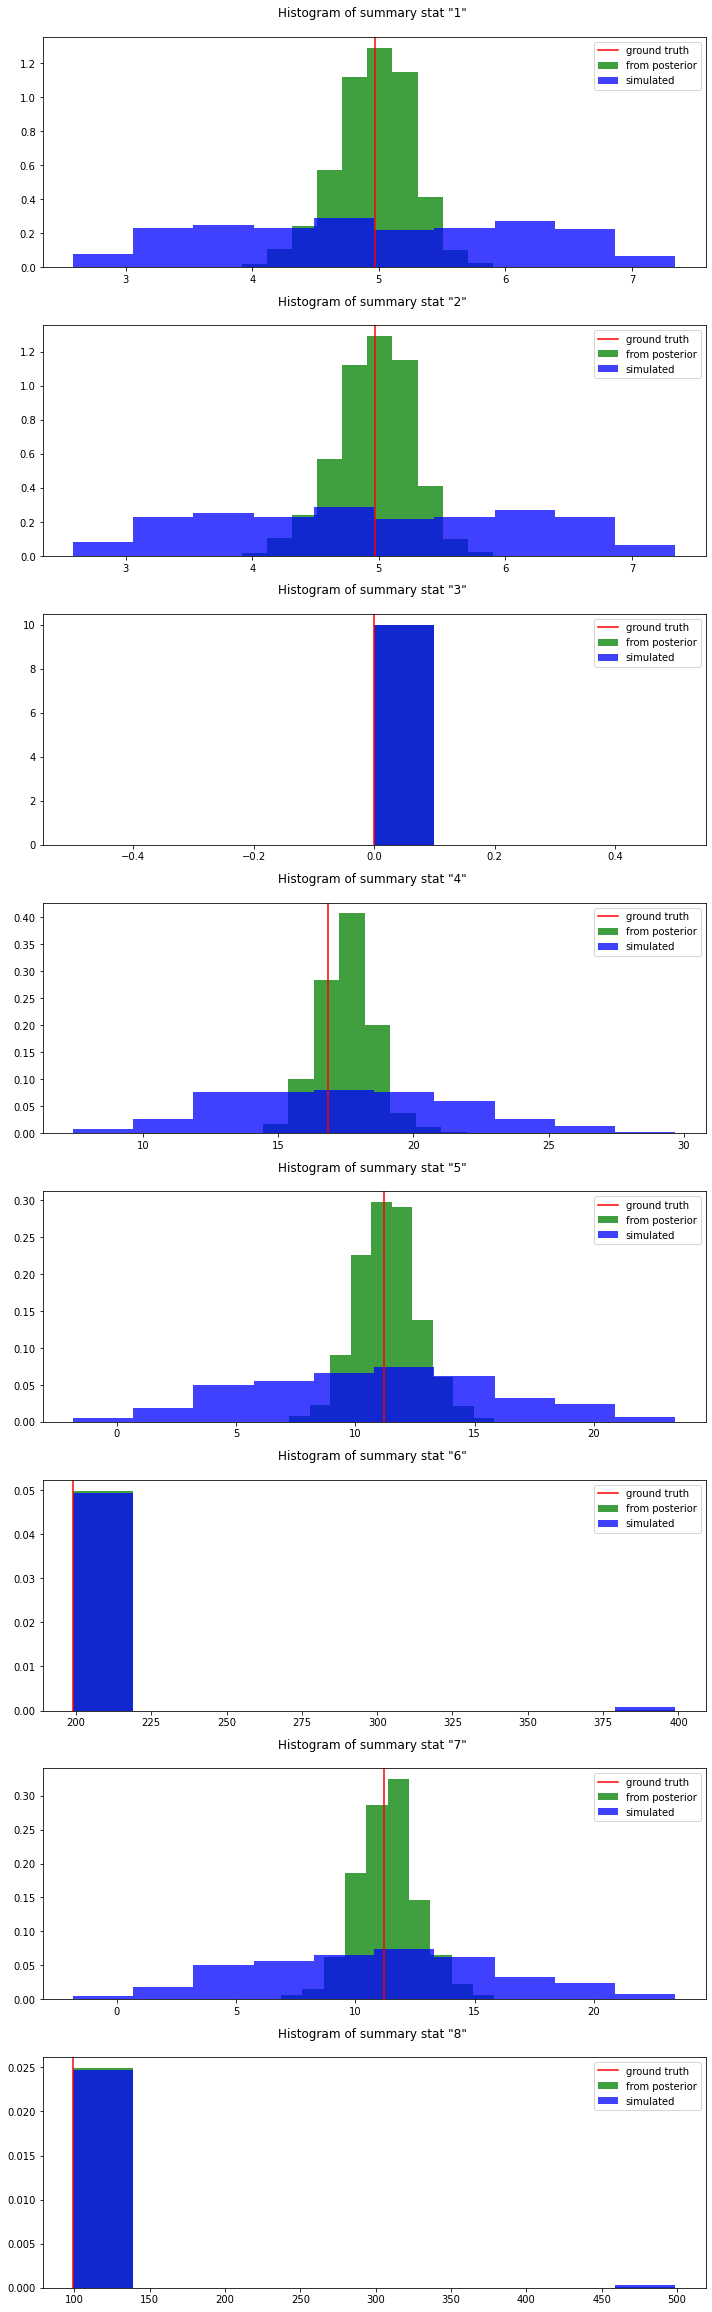

In [52]:
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(10,40), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)
print(len(s_x_stat[0]))

sum_stats_names = torch.arange(1, len(s_x_stat[0]), 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)-1):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)-1):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=True, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=True, facecolor='b', alpha=0.75, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stats[i], color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')